In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from imblearn.over_sampling import SMOTE
from geopy.distance import great_circle

In [2]:
#loading the dataset
fraud_train = pd.read_csv('fraudTrain.csv')
fraud_test = pd.read_csv('fraudTest.csv')

#concatenating the two datasets
data = pd.concat([fraud_train, fraud_test]).reset_index()

data.drop(data.columns[:2], axis=1, inplace=True)
# df.head()
# Load your dataset
# data = pd.read_csv('fraudTest.csv')
print("Original DataFrame:")
print(data.head())

Original DataFrame:
  trans_date_trans_time            cc_num                            merchant  \
0   2019-01-01 00:00:18  2703186189652095          fraud_Rippin, Kub and Mann   
1   2019-01-01 00:00:44      630423337322     fraud_Heller, Gutmann and Zieme   
2   2019-01-01 00:00:51    38859492057661                fraud_Lind-Buckridge   
3   2019-01-01 00:01:16  3534093764340240  fraud_Kutch, Hermiston and Farrell   
4   2019-01-01 00:03:06   375534208663984                 fraud_Keeling-Crist   

        category     amt      first     last gender  \
0       misc_net    4.97   Jennifer    Banks      F   
1    grocery_pos  107.23  Stephanie     Gill      F   
2  entertainment  220.11     Edward  Sanchez      M   
3  gas_transport   45.00     Jeremy    White      M   
4       misc_pos   41.96      Tyler   Garcia      M   

                         street            city  ...      lat      long  \
0                561 Perry Cove  Moravian Falls  ...  36.0788  -81.1781   
1  43039 Ril

In [3]:
# Drop unnecessary columns
data.drop(['trans_date_trans_time', 'merchant', 'category', 'gender', 
           'first', 'last', 'street', 'city', 'state', 
           'job', 'dob', 'trans_num'], axis=1, inplace=True)

In [4]:
# Calculate distance feature
data['distance'] = data.apply(lambda row: great_circle((row['lat'], row['long']), 
                                                         (row['merch_lat'], row['merch_long'])).kilometers, axis=1)


In [5]:
# Feature selection: Focus on latitude and longitude features along with other relevant features
features = ['zip','lat', 'long', 'merch_lat', 'merch_long', 'unix_time', 'distance']
X = data[features]
y = data['is_fraud']  # Target variable

In [6]:
normal = data[data['is_fraud']==0]
fraud = data[data['is_fraud']==1]

In [7]:
fraud_summary = data['is_fraud'].value_counts()

# Print the summary
print("Fraud Summary:")
print(fraud_summary)

# For clearer labeling
print(f"\nNumber of non-fraudulent transactions: {fraud_summary[0]}")
print(f"Number of fraudulent transactions: {fraud_summary[1]}")

Fraud Summary:
is_fraud
0    1842743
1       9651
Name: count, dtype: int64

Number of non-fraudulent transactions: 1842743
Number of fraudulent transactions: 9651


In [8]:
# Preprocess the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# # Apply SMOTE to handle class imbalance
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_scaled, y)


# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# # Reshape the data for CNN input (samples, time steps, features)
# sequence_length = 5  # Define the sequence length
# n_samples = X_resampled.shape[0] // sequence_length
# num_features = X_resampled.shape[1]

# X_reshaped = X_resampled[:n_samples * sequence_length].reshape((n_samples, sequence_length, num_features))
# y_array = y_resampled[:n_samples * sequence_length].reshape((n_samples, sequence_length))
# y_final = y_array[:, -1]

# # Split the reshaped data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_final, test_size=0.2, random_state=42)


# Reshape the data for CNN input (samples, time steps, features)
sequence_length = 5  # Define the sequence length
n_samples = X_resampled.shape[0] // sequence_length
num_features = X_resampled.shape[1]

X_reshaped = X_resampled[:n_samples * sequence_length].reshape((n_samples, sequence_length, num_features))
# Convert y_resampled to a NumPy array for reshaping
y_array = y_resampled.to_numpy()[:n_samples * sequence_length].reshape((n_samples, sequence_length))
y_final = y_array[:, -1]  # Use the last value in each sequence as the target label
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_final, test_size=0.2, random_state=42)


In [10]:
import numpy as np

# Count the occurrences of 0 and 1 in y_train
unique_train, counts_train = np.unique(y_train, return_counts=True)
print("Counts in y_train:")
print(dict(zip(unique_train, counts_train)))

# Count the occurrences of 0 and 1 in y_test
unique_test, counts_test = np.unique(y_test, return_counts=True)
print("\nCounts in y_test:")
print(dict(zip(unique_test, counts_test)))


Counts in y_train:
{0: 294876, 1: 294801}

Counts in y_test:
{0: 73627, 1: 73793}


C:\Users\sachi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
18428/18428 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - accuracy: 0.9803 - loss: 0.0543 - val_accuracy: 0.9971 - val_loss: 0.0178
Epoch 2/20
18428/18428 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step - accuracy: 0.9970 - loss: 0.0181 - val_accuracy: 0.9972 - val_loss: 0.0178
Epoch 3/20
18428/18428 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step - accuracy: 0.9969 - loss: 0.0187 - val_accuracy: 0.9971 - val_loss: 0.0173
Epoch 4/20
18428/18428 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - accuracy: 0.9971 - loss: 0.0179 - val_accuracy: 0.9972 - val_loss: 0.0175
Epoch 5/20
18428/18428 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - accuracy: 0.9971 - loss: 0.0180 - val_accuracy: 0.9971 - val_loss: 0.0176
Epoch 6/20
18428/18428 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.9971 - loss: 0.0179 - val_accuracy: 0.9972 - val_loss: 0.0171
Epoch 7/20
18428/18428 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - accuracy: 0.9969 - loss: 0.0185 - val_accuracy: 0.9972 - val_loss: 0.0173
Epoch 8/20
18428/18428 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step - accuracy: 

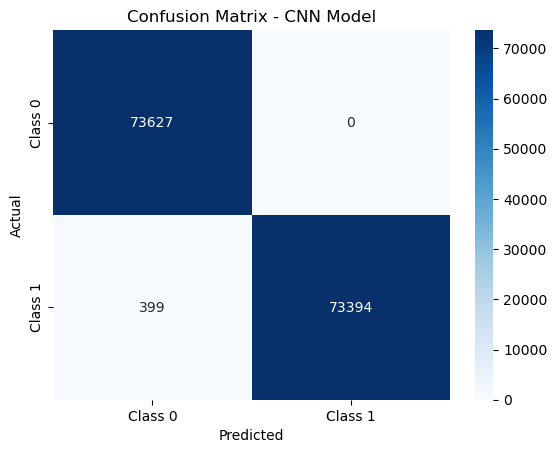

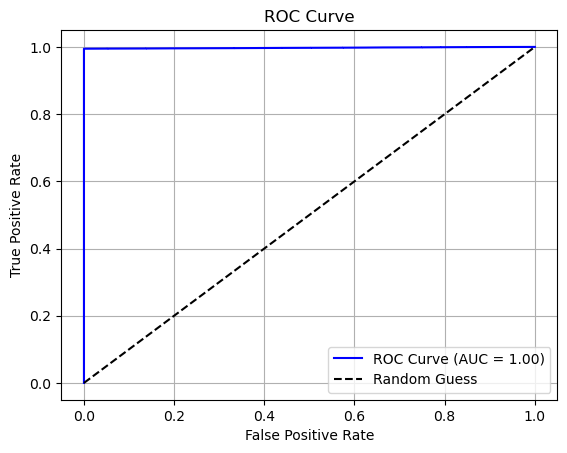

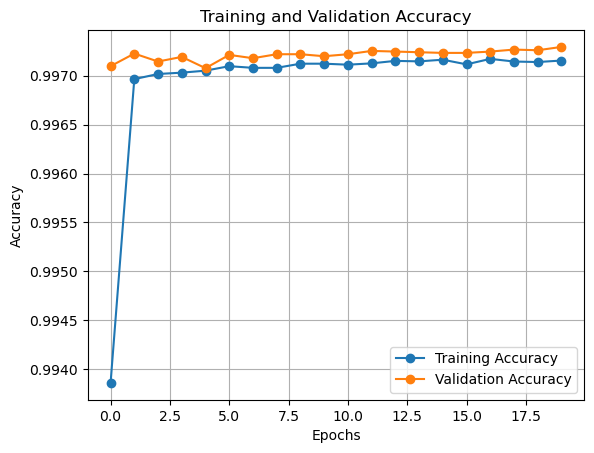

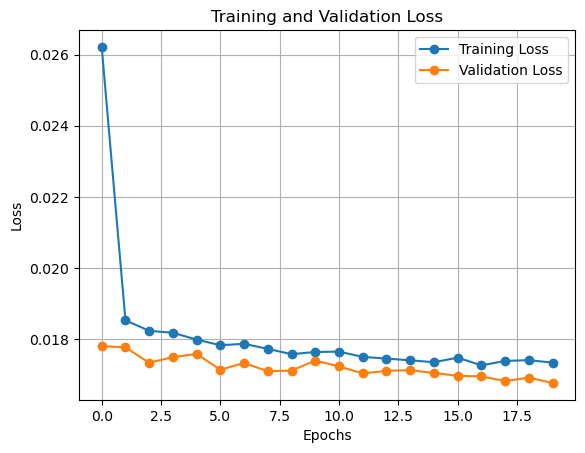

18428/18428 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step
18428/18428 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step
18428/18428 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step
18428/18428 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step
18428/18428 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step
18428/18428 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step
18428/18428 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step
18428/18428 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step
18428/18428 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step
18428/18428 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step
18428/18428 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step
18428/18428 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step
18428/18428 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step
18428/18428 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step
18428/18428 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step
18428/18428 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step
18428/18428 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step
18428/18428 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step
18428/18428 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step
18428/18428 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step


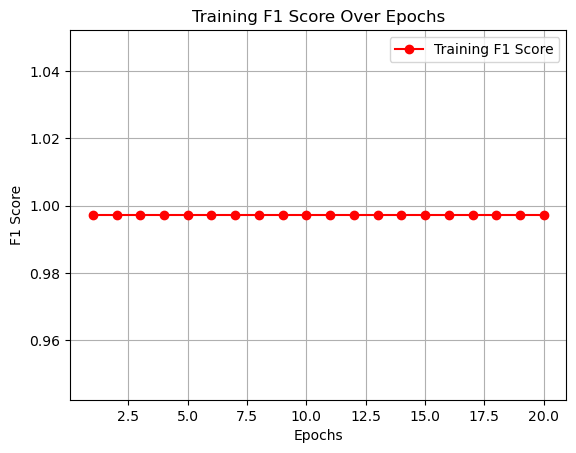

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, auc, classification_report, accuracy_score, confusion_matrix,
    precision_score, recall_score, f1_score
)
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# # Reshape the data for CNN input (samples, time steps, features)
# sequence_length = 5  # Define the sequence length
# n_samples = X_scaled.shape[0] // sequence_length
# num_features = X_scaled.shape[1]

# X_reshaped = X_scaled[:n_samples * sequence_length].reshape((n_samples, sequence_length, num_features))
# y_array = y_resampled.to_numpy()[:n_samples * sequence_length].reshape((n_samples, sequence_length))
# y_final = y_array[:, -1]

# # Split the reshaped data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_final, test_size=0.2, random_state=42)

# Convert labels to categorical format for multi-class problems (not needed for binary classification)
# num_classes = len(np.unique(y_train))
# y_train_cat = to_categorical(y_train, num_classes)
# y_test_cat = to_categorical(y_test, num_classes)

# Build the CNN model
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = cnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model
loss, accuracy = cnn_model.evaluate(X_test, y_test, verbose=0)
print("\nEvaluation Metrics for CNN:")
print(f"Accuracy: {accuracy:.15f}")

# Make predictions
y_pred_prob = cnn_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Calculate metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.15f}')
print(f'Recall: {recall:.15f}')
print(f'F1 Score: {f1:.15f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix - CNN Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

# Training and Validation Accuracy Curve
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

# Training and Validation Loss Curve
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# F1 Score Over Epochs
train_f1_scores = []
for epoch in range(1, 21):
    temp_y_pred = (cnn_model.predict(X_train, batch_size=32) > 0.5).astype(int).flatten()
    temp_f1 = f1_score(y_train, temp_y_pred)
    train_f1_scores.append(temp_f1)

plt.plot(range(1, 21), train_f1_scores, label='Training F1 Score', marker='o', color='red')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training F1 Score Over Epochs')
plt.legend()
plt.grid()
plt.show()
